# Imports

In [2]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns

import tensorflow as tf

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

import pickle

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Load Data

In [3]:
df = pd.concat([pd.read_csv('data_set_ALL_AML_train.csv'),
                pd.read_csv('data_set_ALL_AML_independent.csv')],axis=1)

### Clean & Transpose

In [4]:
patients = [i for i in df.columns if i[:4] != 'call']
df = df.loc[:,patients]
gene_description = df['Gene Description']
df.drop('Gene Description',axis=1,inplace=True)
df.set_index(df.iloc[:,0],inplace=True)
df.drop('Gene Accession Number',axis=1,inplace=True)
df = df.transpose()
df.index = df.index.astype('int64')
df.sort_index(inplace=True)

### Load Target

In [5]:
target = pd.read_csv('actual.csv')
target.set_index('patient',inplace=True)
target.index = target.index.astype('int64')
target.sort_index(inplace=True)
del target.index.name

In [6]:
target.iloc[:,0].value_counts()

ALL    47
AML    25
Name: cancer, dtype: int64

In [7]:
def impute_target(x):
    if x == 'ALL':
        return 1
    else:
        return 0

In [8]:
target['One-hot'] = target['cancer'].apply(lambda x: impute_target(x))

# Neural Net Framework

In [159]:
train = df.iloc[:38,:]
test = df.iloc[38:,:]

target_train = target.iloc[:38,1]
target_test = target.iloc[38:,1]

In [9]:
def subset(rows,columns,data,target):
    return data.iloc[rows,columns], target.iloc[rows]

In [10]:
num_rows = 30
num_cols = 50

train_rows = len(train)
train_cols = len(train.columns)

test_rows = len(test)

In [25]:
#with open("genes.txt", "rb") as fp:
#    genes = pickle.load(fp)
#
#with open("predictions.txt", "rb") as fp:
#    predictions = pickle.load(fp)
#
#with open("accuracies.txt", "rb") as fp:
#    accuracies = pickle.load(fp)
#
#
#genes = []
#predictions = []
#accuracies = []

In [12]:
reps = 180
for iters in range(reps): 
    #Suppress output except for error messages
    tf.logging.set_verbosity(tf.logging.ERROR)

    #Select Rows and Cols
    rows = random.sample(range(train_rows),num_rows)
    cols = random.sample(range(train_cols),num_cols)

    #Save Genes used for model
    genes.append(train.columns[cols])

    #feature columns
    feature_columns = []
    for i in train.columns[cols]:
        feature_columns.append(tf.feature_column.numeric_column(i))

    #Model Initialization
    classifier = tf.estimator.DNNClassifier(
        feature_columns=feature_columns,
        hidden_units=[25, 10, 5],
        optimizer=tf.train.AdamOptimizer(1e-2),
        n_classes=2,
        dropout=0.2,
    )

    #Input Function
    train_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=subset(rows,cols,train,target_train)[0],
        y=subset(rows,cols,train,target_train)[1],
        num_epochs=10,
        batch_size=num_rows,
        shuffle=True
    )

    #model training
    classifier.train(input_fn=train_input_fn, steps=1000)

    #eval function
    test_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=test.iloc[:,cols],
        y=target_test.iloc[:],
        num_epochs=1,
        shuffle=False
    )

    #predictions
    preds = list(classifier.predict(test_input_fn))

    pred_class = [p["classes"] for p in preds]

    preds = []

    for i in range(len(pred_class)):
        preds.append(int(pred_class[i][0]))

    predictions.append(preds)

    accuracies.append(accuracy_score(target_test,preds))

In [13]:
#with open('genes.txt', 'wb') as fp:
#    pickle.dump(genes, fp)
#
#with open('predictions.txt', 'wb') as fp:
#    pickle.dump(predictions, fp)
#    
#with open('accuracies.txt', 'wb') as fp:
#    pickle.dump(accuracies, fp)

# Weighting Models

In [45]:
#Convert Predictions to -1/+1
for i in range(len(predictions)):
    for j in range(len(predictions[i])):
        if predictions[i][j] == 0:
            predictions[i][j] = -1

In [ ]:
#Convert Target Test Final Values
target_final = [-1 if i==0 else i for i in target_test]

In [105]:
def final_preds(pred_list,weights):
    final_preds = []
    for i in range(len(pred_list[0])):
        pred_sum = 0
        for j in range(len(pred_list)):
            pred_sum += pred_list[j][i]*weights[j]
        if pred_sum == 0:
            final_preds.append(pred_sum)
        else:
            final_preds.append(pred_sum/abs(pred_sum))
    return final_preds

In [74]:
#Every model is treated equally
weights1 = [1] * len(accuracies)

#Final Predictions
final_preds1 = final_preds(predictions,weights1)

#Accuracy
accuracy_score(target_final,final_preds1)

0.5882352941176471

In [75]:
#Every model is weighted by its accuracy
final_preds2 = final_preds(predictions,accuracies)

#Accuracy
accuracy_score(target_final,final_preds2)

0.5882352941176471

In [26]:
#Cut off all models that predicted majority class only or performed worse
mode = max(set(accuracies), key=accuracies.count)
weights3 = []

for i in accuracies:
    if i <= mode:
        weights3.append(0)
    else:
        weights3.append(i-mode)

In [27]:
#Weight each model by above logic
final_preds3 = final_preds(predictions,weights3)

#Accuracy
accuracy_score(target_final,final_preds3)

NameError: name 'final_preds' is not defined

In [28]:
#Apply exponential to weights3

weights4 = []

for i in weights3:
    weights4.append(np.exp(i)-1)

In [96]:
#Weight each model by scaled weight
final_preds4 = final_preds(predictions,weights4)

#Accuracy
accuracy_score(target_final,final_preds4)

0.8529411764705882

In [106]:
def ensemble(predictions,weights,target):
    acc_list = []
    for i in range(len(predictions)):
        ens_preds = final_preds(predictions[:(i+1)],weights[:(i+1)])
        acc_list.append(accuracy_score(target,ens_preds))
    return acc_list

In [107]:
acc_list1 = ensemble(predictions,weights1,target_final)

In [114]:
acc_list2 = ensemble(predictions,accuracies,target_final)

In [117]:
acc_list3 = ensemble(predictions,weights3,target_final)

In [118]:
acc_list4 = ensemble(predictions,weights4,target_final)

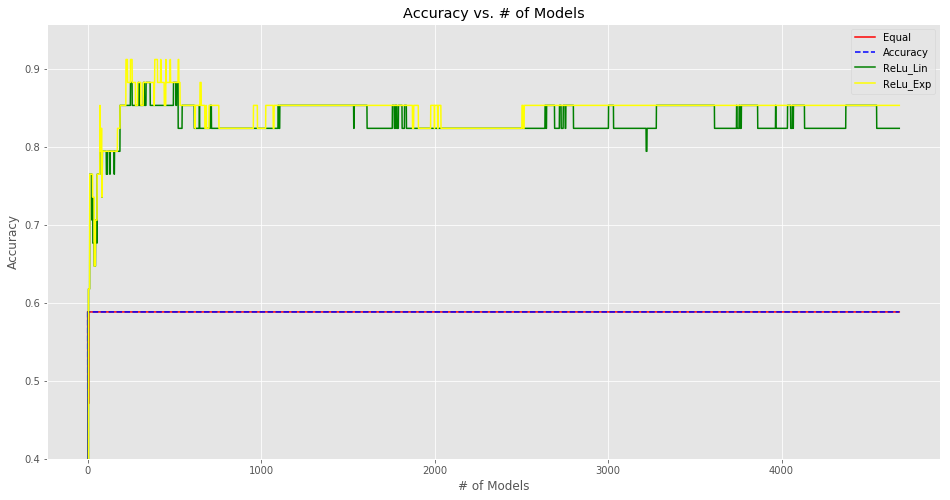

In [129]:
plt.figure(figsize = (16,8))

plt.plot(acc_list1,color='red',label='Equal')
plt.plot(acc_list2,'b--',label='Accuracy')
plt.plot(acc_list3,color='green',label='ReLu_Lin')
plt.plot(acc_list4,color='yellow',label='ReLu_Exp')

plt.title('Accuracy vs. # of Models')
plt.xlabel('# of Models')
plt.ylabel('Accuracy')
plt.ylim(bottom=0.4)
plt.legend()

# Scoring Genes

In [23]:
num_genes = len(df.columns)

gene_ave = pd.Series(data=np.zeros(num_genes),index=df.columns)

In [29]:
#If a gene is used in a model, add that model's weight to the gene's score

for i in gene_ave.index:
    count = 0
    for j in range(len(genes)):
        if i in genes[j]:
            gene_ave[i] = ((gene_ave[i]*count) + weights4[j]) / (count + 1)
            count += 1

In [30]:
print(gene_ave.nlargest(10))

Gene Accession Number
M84526_at         0.130503
M27891_at         0.098724
X17042_at         0.085896
M96326_rna1_at    0.081391
M19507_at         0.075443
M11147_at         0.072073
L19161_at         0.068326
M27783_s_at       0.068207
J03909_at         0.066297
D38024_at         0.064881
dtype: float64


# Linear Classifers of Top 50

In [163]:
top50 = gene_score.nlargest(50).index

In [164]:
train50 = train.loc[:,top50]
test50 = test.loc[:,top50]

In [165]:
#Test different numbers of neighbors
n = 10
KNN_acc = []
for i in range(n):
    KNN_model = KNeighborsClassifier(n_neighbors=i+1)
    KNN_model.fit(train50,target_train)
    KNN_preds = KNN_model.predict(test50)
    KNN_acc.append(accuracy_score(target_test,KNN_preds))

In [167]:
KNN_model = KNeighborsClassifier(n_neighbors=3)
KNN_model.fit(train50,target_train)
KNN_preds = KNN_model.predict(test50)
accuracy_score(target_test,KNN_preds)

0.9411764705882353

In [215]:
SVM_model = SVC(C= 1, kernel='linear')
SVM_model.fit(train50,target_train)
SVM_preds = SVM_model.predict(test50)
accuracy_score(target_test,SVM_preds)

0.9411764705882353

# Compare Top 50 to Paper's Top 50

In [43]:
golub_genes = ['U22376','X59417','U05259','M92287','M31211',
               'X74262','D26156','S50223','M31523','L47738',
               'U32944','Z15115','X15949','X63469','M91432',
               'U29175','Z69881','U20998','D38073','U26266',
               'M31303','Y08612','U35451','M29696','M13792',
               'M55150','X95735','U50136','M16038','U82759',
               'M23197','M84526','Y12670','M27891','X17042',
               'Y00787','M96326','U46751','M80254','L08246',
               'M62762','M28130','M63138','M57710','M69043',
               'M81695','X85116','M19045','M83652','X04085']

In [144]:
my50_id = [i[:6] for i in gene_ave.nlargest(50).index]

In [145]:
count = 0
for i in my50_id:
    if i in golub_genes:
        count += 1
print(count)

7


# Optimize KNN model

In [190]:
gene_id = [i[:6] for i in df.columns]

In [131]:
top10 = gene_ave.nlargest(50).index

In [160]:
train10 = train.loc[:,top10]
test10 = test.loc[:,top10]
df10 = df.loc[:,top10]

In [133]:
#Test different numbers of neighbors
n = 10
KNN_acc50 = []
for i in range(n):
    KNN_model = KNeighborsClassifier(n_neighbors=i+1)
    cv = cross_val_score(KNN_model,train10,target_train,cv=5)
    KNN_acc50.append(cv.mean())

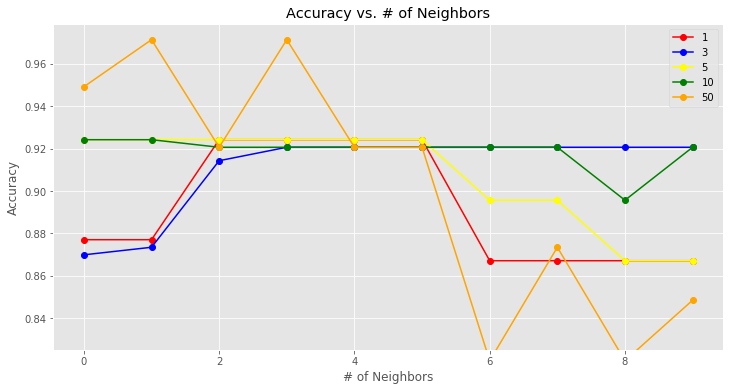

In [121]:
plt.figure(figsize=(12,6))

plt.plot(KNN_acc1, color='red',marker='o', label='1')
plt.plot(KNN_acc3, color='blue',marker='o', label='3')
plt.plot(KNN_acc5, color='yellow',marker='o', label='5')
plt.plot(KNN_acc10, color='green',marker='o', label='10')
plt.plot(KNN_acc50, color='orange',marker='o', label='50')

plt.title('Accuracy vs. # of Neighbors')
plt.xlabel('# of Neighbors')
plt.ylabel('Accuracy')
plt.ylim(bottom=0.825)
plt.legend()

# Stats on genes

In [136]:
from scipy import stats

In [142]:
p_vals = []

for i in top10:
    weight_arr = []
    for j in range(len(genes)):
        if i in genes[j]:
            weight_arr.append(weights4[j])
    p = stats.ttest_1samp(weight_arr,0)[1]
    p_vals.append(p)

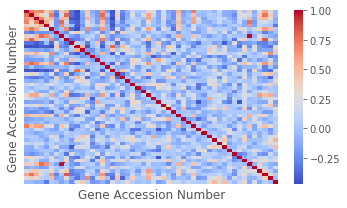

In [155]:
plt.figure(figsize=(5,3))
sns.heatmap(df10.corr(),cmap='coolwarm',xticklabels=False,yticklabels=False)
plt.tight_layout()